In [1]:
import os
import re
import sys
import pandas as pd
import numpy as np

In [2]:
"""
 data_source should be plain text content.  Content will be parsed for sentences.
 This is NOT a csv file with classes.
"""
view_tokens=False
#data_source = 'data/fairy_tales_every_child_should_know_pg14916.txt'
data_source = 'data/medical_docs_content.txt'

# We're just creating the model_path here, we don't use it till next section.
model_path  = "models/{}".format(re.compile(r'\..*').sub('', os.path.basename(data_source)))


#open input file and tokenize
tokens = []
with open(data_source, 'r') as source:
    for line in source:
        line = re.sub(r'\W', ' ', line) 
        line_tokens = line.split( )
        line_tokens = [token.strip().lower() for token in line_tokens]
        tokens.append(line_tokens)

if (view_tokens):
    for idx in range(2):
        print tokens[idx]
print "DONE creating tokens, saved in variable 'tokens'"

DONE creating tokens, saved in variable 'tokens'


In [3]:
"""
 Source: Natural Language Processing in Action, Chapter 6
 Section: 6.5.2 Training domain specific word2vec model
 Section:
     Input: tokens, Tokenized data from previous step.
     Input: model_path, path where we will saved trained model from tokens
"""
from gensim.models import word2vec

model = word2vec.Word2Vec(
    tokens,              # Our array of sentences, each of which is an array of words.
    min_count=3,         # Min number of word count to be considered
    workers=4,           # Number of threads in parallel. (cores on laptop)
    size=300,            # The number of weights in hidden layer, (length of word verctors)
    window=6,            # Context window size
    sample=1e-3          # subsampling rate for frequent terms
)

# Save disk space by saving only hidden neurons.  (We lose output weights)
model.init_sims(replace=True)

model.save(model_path)

print "DONE"

DONE


In [4]:
import pandas as pd
from gensim.models import KeyedVectors
from gensim.models import word2vec
model = word2vec.Word2Vec.load(model_path)
results = model.most_similar(positive=['blogs'], negative=[], topn=20)
#print results
data = pd.DataFrame(results)
print data.head(10)

word_vectors = KeyedVectors.load(model_path)
print model.similar_by_vector(word_vectors['medical'], topn=1)


              0         1
0    creatively  0.941491
1  contributing  0.935837
2     trainings  0.932586
3        commit  0.927577
4       matters  0.926284
5        curved  0.925072
6     coworkers  0.922802
7  temperatures  0.920693
8           vat  0.920182
9       hearing  0.920156
[('medical', 1.0)]


In [5]:
"""
This section creates the semantic map from the hidden layer vectors.
	1. Open a pretrained vector set 'data_for_classification_model'
	2. collect all vectors into one single 2d numpy array
	3. pass 2d array to minisom and train a map
	4. Save the map to som_map
    
    Inputs:
    model_path, was set previously pointing to the model trained from raw text
    Outputs:
    vectors_path
    weights_path
    
"""
from ptpython.repl import embed
from minisom import MiniSom
from gensim.models import KeyedVectors
from gensim.models import word2vec
import numpy as np 

#INPUTS
b_collect_new_vectors = False
b_save_new_som_weights = True 
#OUTPUTS
vectors_path = 'models/vectors_array'
weights_path = 'models/som_weights_3'
# TRAINING INPUTS
_sigma = 5
_learning_rate = 0.8
_train_iterations = 200
#ENDINPUTS


print "Loading model {}".format(model_path)
word_vectors = KeyedVectors.load(model_path)
model = word2vec.Word2Vec.load(model_path)

if (b_collect_new_vectors):
    print "Saving 2d numpy array from word_vectors to {}".format(vectors_path)
    varrs = np.array([word_vectors[word] for word in word_vectors.wv.vocab.keys()])
    np.save(vectors_path, varrs)
else:
    print "Loading {}.py word vectors from disk".format(vectors_path)
    varrs = np.load("{}.npy".format(vectors_path))

print varrs.shape
som = MiniSom(x=128, y=128, input_len=300, sigma=_sigma, learning_rate=_learning_rate)
som.random_weights_init(varrs)
if (b_save_new_som_weights):
    print "Training:"
    print "sigma:", _sigma, "learning_rate:", _learning_rate, "train_iterations:",_train_iterations
    som.train_random(varrs, _train_iterations) # random training

    print "Saving {}".format(weights_path)
    np.save(weights_path, som.weights)


            
print "DONE"

Loading model models/medical_docs_content
Loading models/vectors_array.py word vectors from disk
(53561, 300)
Training:
sigma: 5 learning_rate: 0.8 train_iterations: 200
Saving models/som_weights_3
DONE


Loading weights
Importing from data file
Saving figure to fingerprints/0.png
Saving figure to fingerprints/1.png
Saving figure to fingerprints/2.png
Saving figure to fingerprints/3.png
Saving figure to fingerprints/4.png
DONE


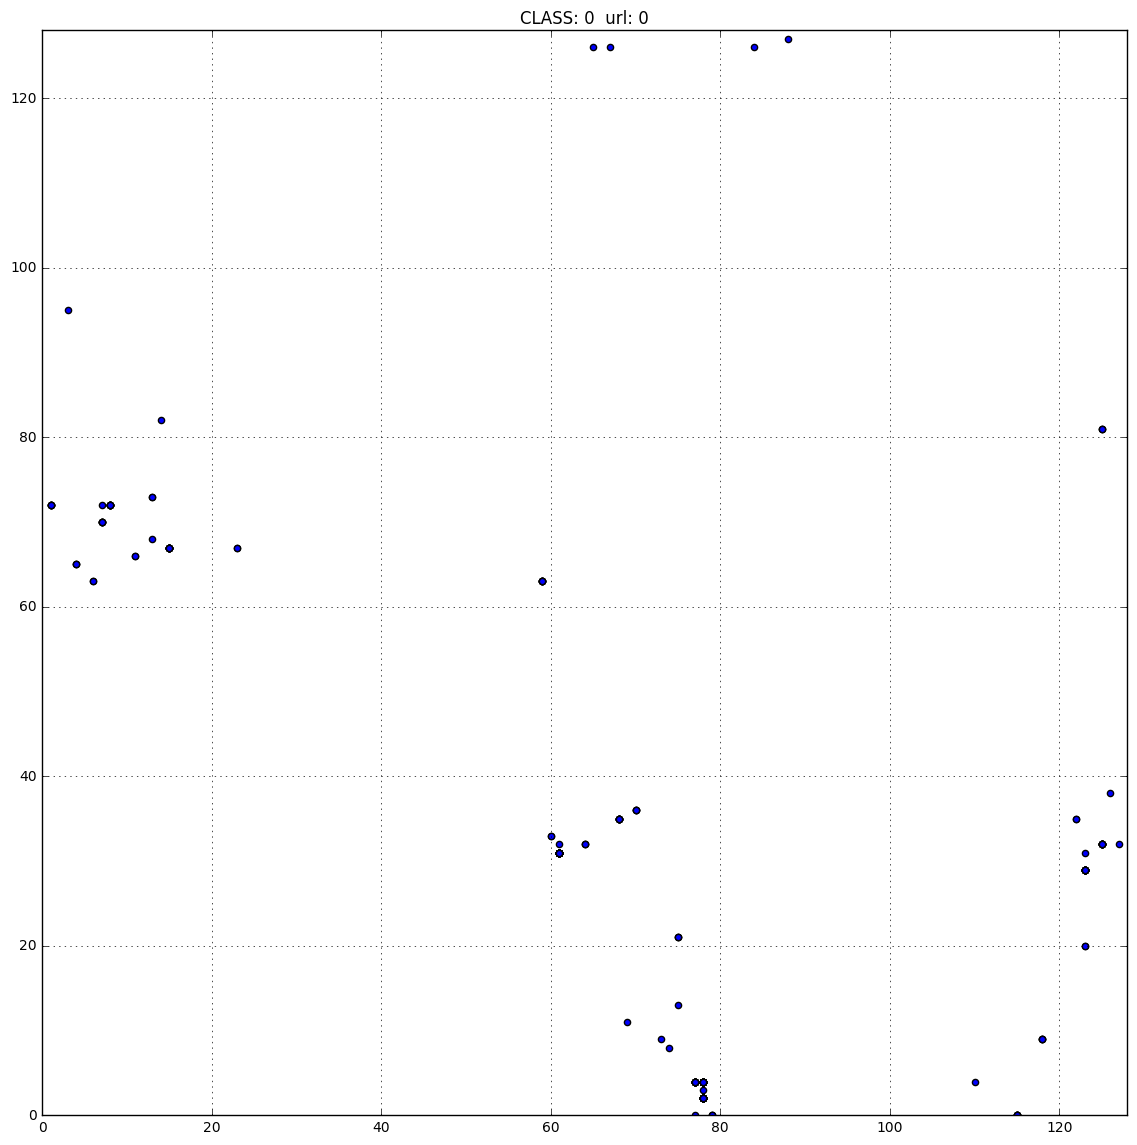

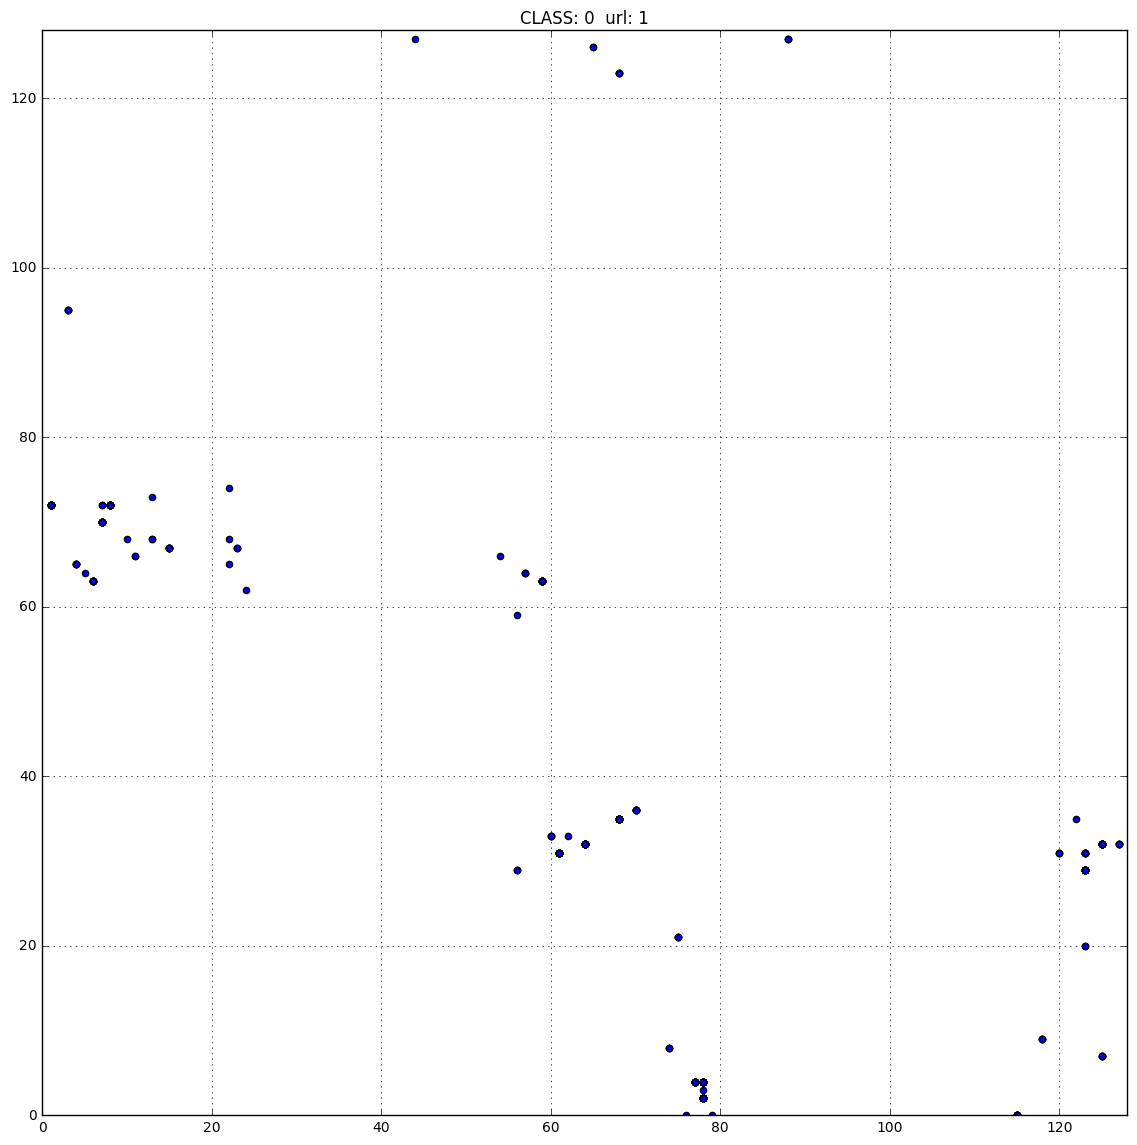

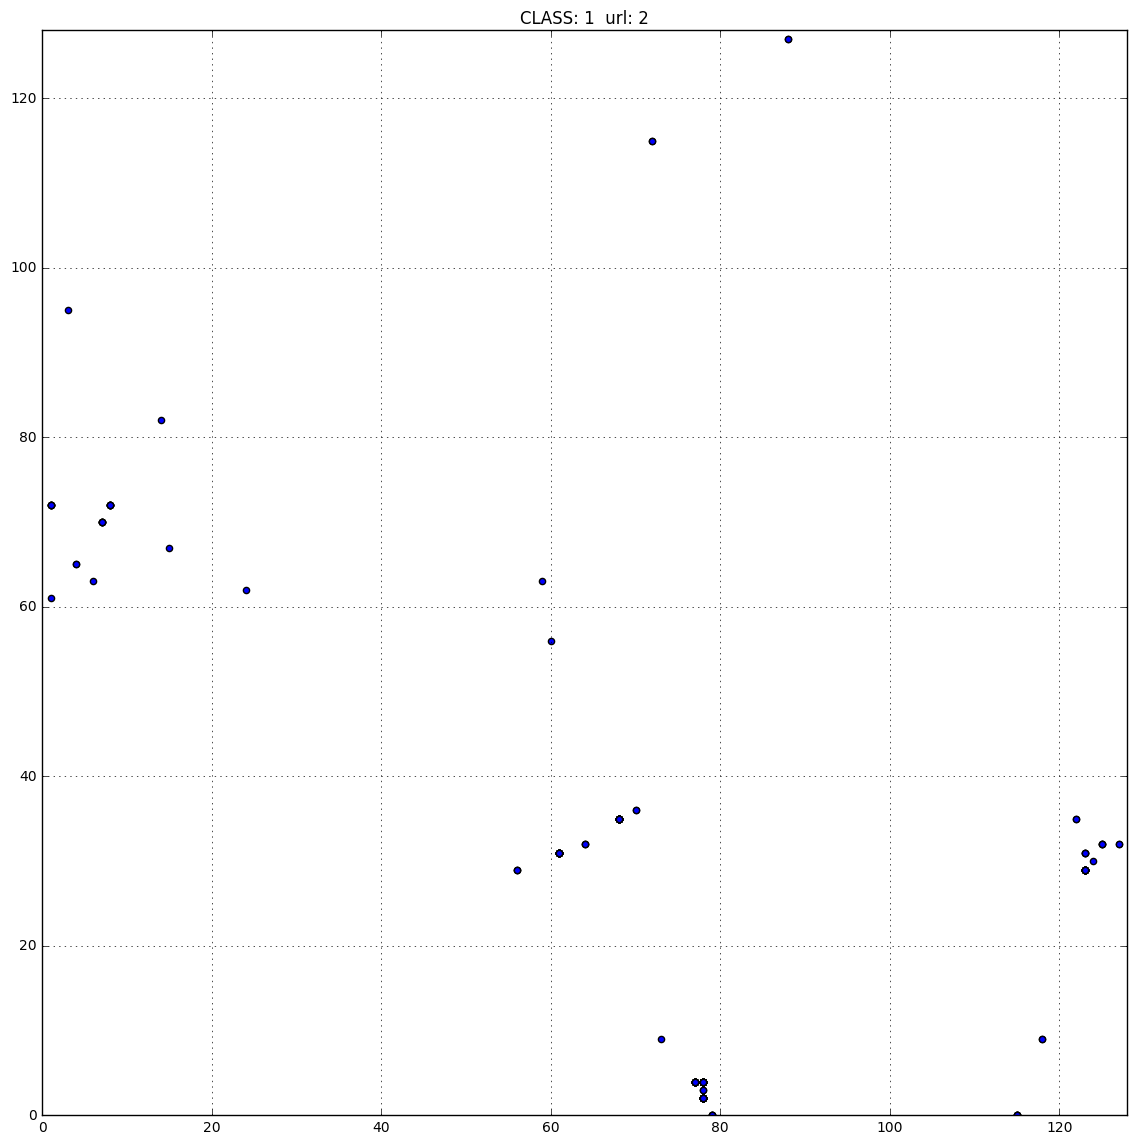

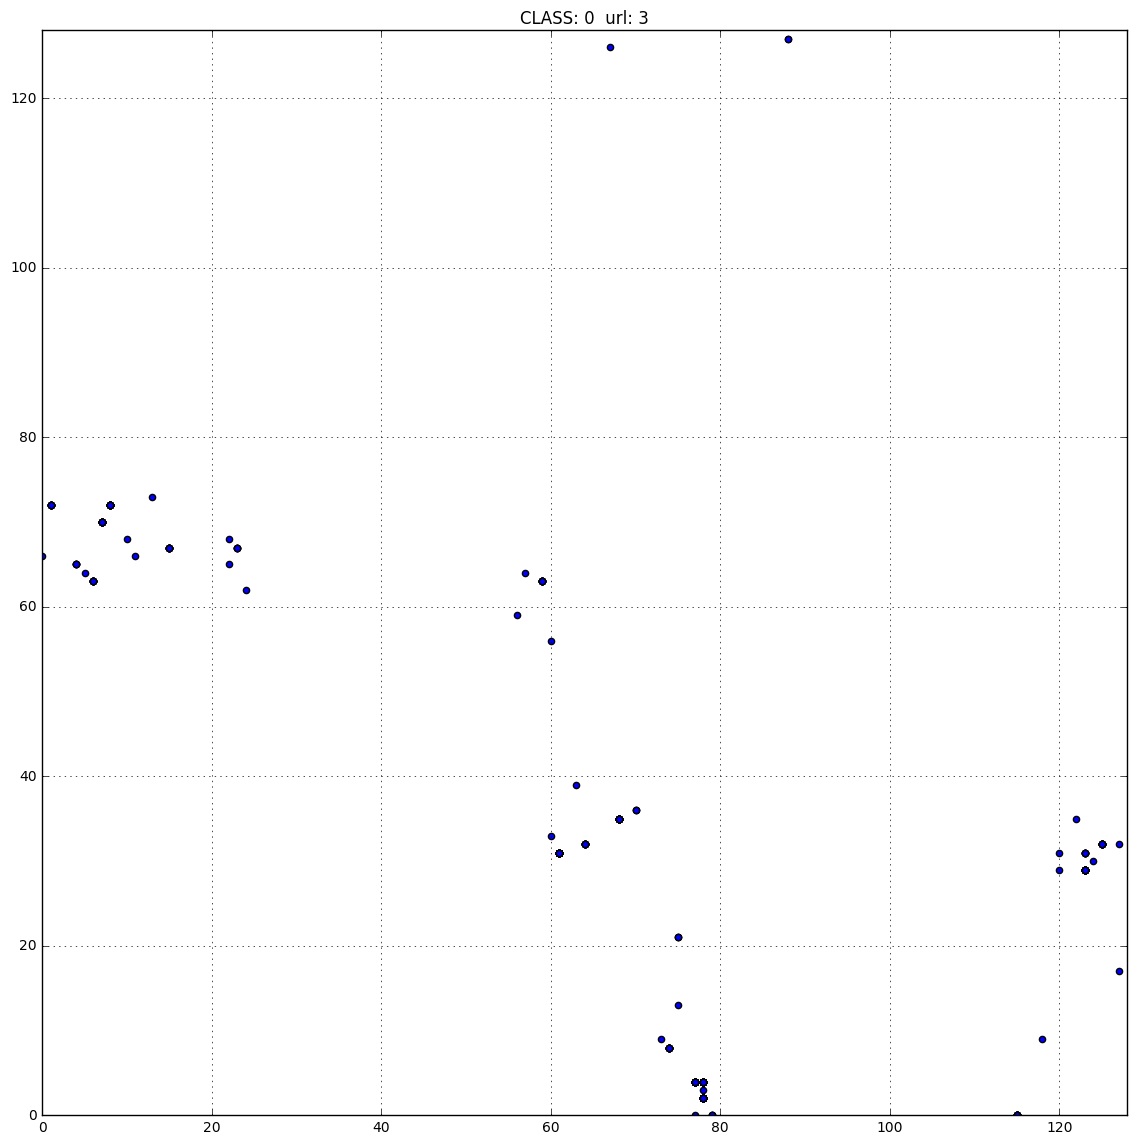

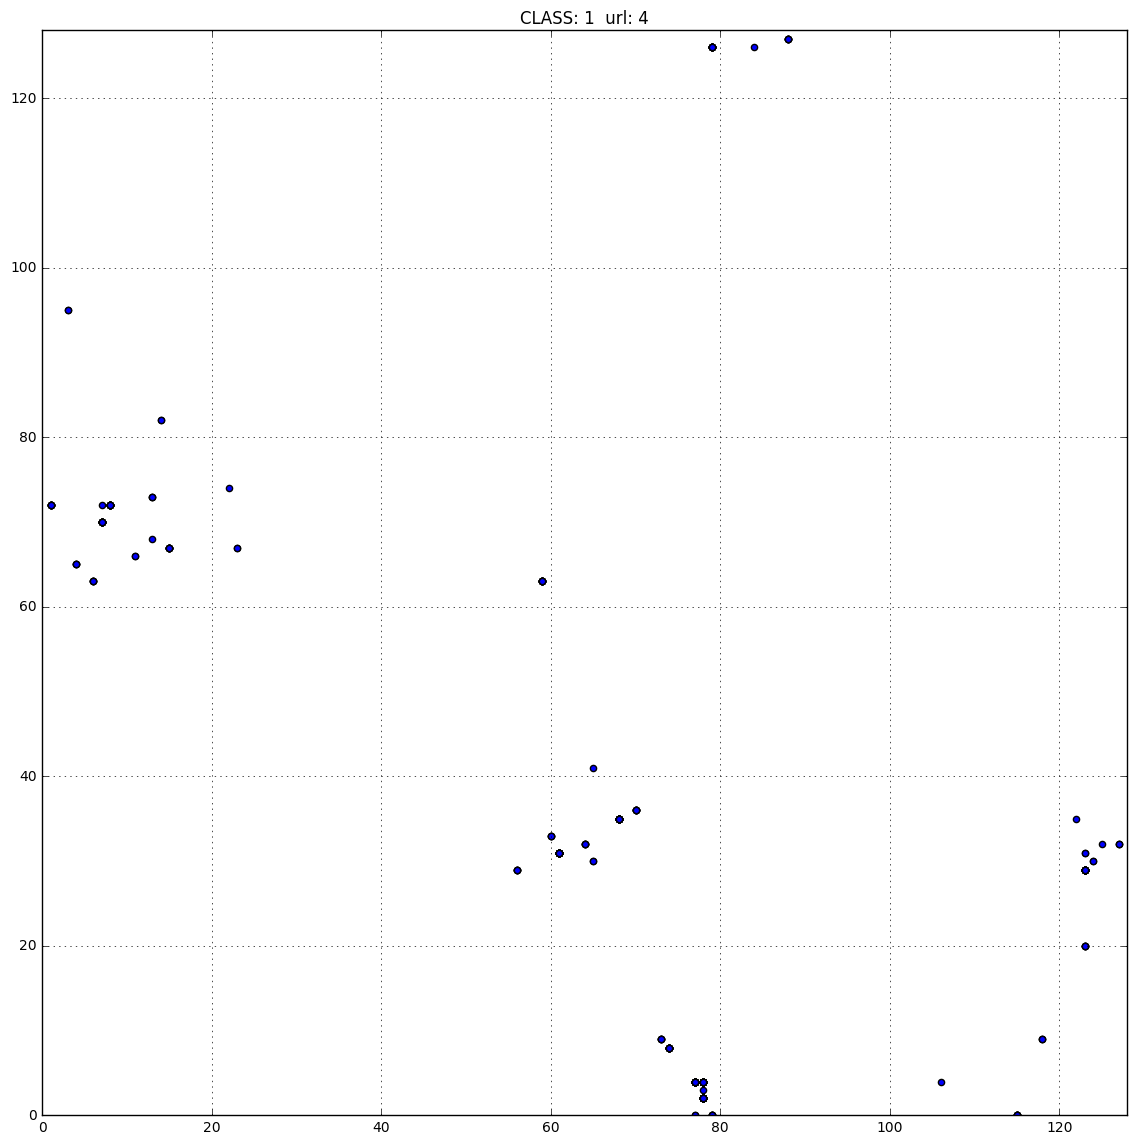

In [11]:
import csv

def import_from_data_file(url):
    with open(data_source, 'r') as source:
        csvfile = csv.reader(source)
        for line in csvfile:
            binary = line[6]
            if url == line[0].strip():
                row_els = [word.lower().strip() for word in line[8].split(' ')]
                return binary, row_els
            else:
                continue
    print "URL NOT FOUND IN SOURCE FILE"
    return 0, []

import matplotlib.pyplot as plt
%matplotlib inline

data_source = 'data/medical_docs_with_id.csv'
weights_path = 'models/som_weights_3'
print "Loading weights"
som.weights = np.load("{}.npy".format(weights_path))


print "Importing from data file"
for id in range(5):
    url = str(id)
    binary, words = import_from_data_file(url)
    arrx = []
    arry = []

    for word in words:
        try:
            x, y = som.winner(word_vectors[word])
            arrx.append(x)
            arry.append(y)
            #print word, str(x), str(y)
        except:
            pass
    #print "Plotting figure"
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(arrx,arry)
    plt.axis([0,128,0,128])
    plt.grid()
    print "Saving figure to fingerprints/{}.png".format(url)
    plt.title("CLASS: {}  url: {}".format(str(binary), url))
    plt.savefig("fingerprints/{}.png".format(url))
    #plt.show()
    
# early_exit = 120
# with open('data/urls_by_length.txt', 'r') as source:
#     stop = 1
#     idx = 0
#     for line in source.readlines():
#         if early_exit < 0:
#             break
#         early_exit -= 1
#         url = line.split(' ')[2].strip()
#         if idx > stop:
#             idx += 1
#             continue
#         print "Processing url {}".format(url)
#         binary, words = import_from_data_file(url)
#         #print "Calculating x y coordinates of words"
#         arrx = []
#         arry = []
#         print "Length of words", len(words)
        
#         for word in words:
#             try:
#                 x, y = som.winner(word_vectors[word])
#                 arrx.append(x)
#                 arry.append(y)
#                 #print word, str(x), str(y)
#             except:
#                 pass


#         #print "Plotting figure"
#         fig = plt.figure(figsize=(14,14))
#         ax = fig.add_subplot(1,1,1)
#         ax.scatter(arrx,arry)
#         plt.axis([0,128,0,128])
#         plt.grid()
#         print "Saving figure to fingerprints/{}.png".format(url)
#         plt.title("CLASS: {}  url: {}".format(str(binary), url))
#         plt.savefig("fingerprints/{}.png".format(url))
#         #plt.show()
print "DONE"